In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
classes = ["stop_sign","person","bicycle","bus","truck","car","motorbike","reflective_cone","ashcan","warning_column",
               "spherical_roadblock","pole","dog","tricycle","fire_hydrant"]

In [4]:
PathToDataset = "/content/drive/MyDrive/ssd-object-detection-master/data/dataset/Obstacle Dataset"
TrainImage = PathToDataset + "/img-train/"
valImage = PathToDataset + "/img-val/"
testImage = PathToDataset + "/img-test/"
trainAnn = PathToDataset + "/ann-train/"
testAnn =  PathToDataset + "/ann-test/"
valAnn = PathToDataset + "/ann-val/"

In [8]:
def get_dataframe(annotations_path):
    D =    {'image_name' : [],
            'num_objects': [],
            'BB_xywh': [],
            'object_ids' : []}    
    for line in open(annotations_path, 'r'):
        image_name, num_objects, *annotations = line.split()
        annotations_list = [list(map(int, annotations[i:i+4])) for i in range(0, len(annotations), 5)]
        object_id_list = [int(annotations[i+4]) for i in range(0, len(annotations), 5)]
        D['image_name'].append(image_name)
        D['num_objects'].append(num_objects)
        D['BB_xywh'].append(annotations_list)
        D['object_ids'].append(object_id_list)    
    df = pd.DataFrame(D)
    return df

In [5]:
import os 
import numpy as np
import xml.etree.ElementTree as ET
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd 

def extract_single_xml_file(tree):
    Nobj = 0
    row  = OrderedDict()
    anotationList = []
    nameList = []
    idList = []
    boxes = []
    for elems in tree.iter():

        if elems.tag == "object":
            for elem in elems:
                if elem.tag == "name":
                    idList.append(int(classes.index(str(elem.text))))             
                if elem.tag == "bndbox":
                    for k in elem:
                      boxes.append(int(k.text))
                    anotationList.append(boxes)
                    boxes = []
            Nobj += 1
                    
    row["num_objects"] = Nobj
    row["BB_xywh"] = anotationList
    row["object_ids"] = idList
    return(row)

In [6]:
train_anno = []
for fnm in os.listdir(trainAnn):  
    if not fnm.startswith('.'): ## do not include hidden folders/files
        tree = ET.parse(os.path.join(trainAnn,fnm))
        row = extract_single_xml_file(tree)
        row["image_name"] = fnm.split(".")[0]+".jpg"
        train_anno.append(row)
train_anno = pd.DataFrame(train_anno)
maxNobj = np.max(train_anno["num_objects"])

In [7]:
print("columns in df_anno\n-----------------")
for icol, colnm in enumerate(train_anno.columns):
    print("{:3.0f}: {}".format(icol,colnm))
print("-"*30)
print("df_anno.shape={}=(N frames, N columns)".format(train_anno.shape))
train_anno.head()

columns in df_anno
-----------------
  0: num_objects
  1: BB_xywh
  2: object_ids
  3: image_name
------------------------------
df_anno.shape=(4566, 4)=(N frames, N columns)


,num_objects,BB_xywh,object_ids,image_name
0,7,"[[478, 307, 640, 485], [5, 331, 86, 485], [0, ...","[5, 5, 5, 5, 4, 1, 1]",000000232551.jpg
1,6,"[[516, 183, 564, 200], [480, 179, 526, 197], [...","[5, 5, 5, 5, 4, 5]",000000163897.jpg
2,3,"[[183, 328, 213, 379], [417, 139, 448, 199], [...","[1, 1, 12]",000000062347.jpg
3,17,"[[202, 185, 439, 342], [0, 162, 237, 319], [92...","[6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, ...",000000063782.jpg
4,1,"[[1, 114, 602, 541]]",[12],000000100500.jpg


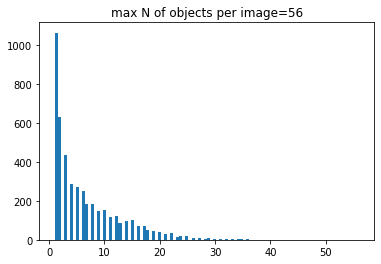

In [8]:
plt.hist(train_anno["num_objects"].values,bins=100)
plt.title("max N of objects per image={}".format(maxNobj))
plt.show()

In [9]:
val_anno = []
for fnm in os.listdir(valAnn):  
    if not fnm.startswith('.'): ## do not include hidden folders/files
        tree = ET.parse(os.path.join(valAnn,fnm))
        row = extract_single_xml_file(tree)
        row["image_name"] = fnm.split(".")[0]+".jpg"
        val_anno.append(row)
val_anno = pd.DataFrame(val_anno)
maxNobj = np.max(val_anno["num_objects"])

In [10]:
print("columns in df_anno\n-----------------")
for icol, colnm in enumerate(val_anno.columns):
    print("{:3.0f}: {}".format(icol,colnm))
print("-"*30)
print("df_anno.shape={}=(N frames, N columns)".format(val_anno.shape))
val_anno.head()

columns in df_anno
-----------------
  0: num_objects
  1: BB_xywh
  2: object_ids
  3: image_name
------------------------------
df_anno.shape=(766, 4)=(N frames, N columns)


,num_objects,BB_xywh,object_ids,image_name
0,1,"[[80, 111, 144, 210]]",[7],0524276.jpg
1,1,"[[379, 2, 493, 783]]",[11],06080001.jpg
2,6,"[[1731, 172, 1876, 270], [950, 168, 1207, 261]...","[6, 5, 7, 7, 11, 11]",0000679.jpg
3,17,"[[2827, 1242, 3525, 1969], [3319, 1315, 3958, ...","[6, 6, 1, 1, 1, 6, 2, 1, 1, 1, 7, 7, 7, 7, 7, ...",0006206.jpg
4,1,"[[414, 295, 512, 555]]",[7],0524180.jpg


In [11]:
%cd /content/drive/My Drive/ssd-object-detection-master

/content/drive/My Drive/ssd-object-detection-master


In [12]:
import utils
import torch
from ssdconfig import SSDConfig
from data import ShelfImageDataset, collate_fn, get_dataframe
from torch.utils.data import DataLoader
from torch.optim import SGD
from ssd import SSD, MultiBoxLoss
from trainer import train, eval

config = SSDConfig()
device = config.DEVICE


config.PATH_TO_CHECKPOINT = "/content/drive/My Drive/ssd-object-detection-master/checkpoint/checkpoint_ssd_1.pth.tar"

config.PRINT_FREQ = 35
config.VGG_BN_FLAG = True
config.TRAIN_BATCH_SIZE = 16
config.LEARNING_RATE = 0.001
config.USE_PRETRAINED_VGG = True
config.NUM_ITERATIONS_TRAIN = 2500 

In [13]:
dataset_tr = ShelfImageDataset(train_anno, TrainImage, train=True)
dataloader_tr = DataLoader(dataset_tr,
                           shuffle=True,
                           collate_fn=collate_fn,
                           batch_size=config.TRAIN_BATCH_SIZE,
                           num_workers=config.NUM_DATALOADER_WORKERS)

dataset_te = ShelfImageDataset(val_anno, valImage, train=False)
dataloader_te = DataLoader(dataset_te,
                           shuffle=True,
                           collate_fn=collate_fn,
                           batch_size=config.TRAIN_BATCH_SIZE,
                           num_workers=config.NUM_DATALOADER_WORKERS)

In [14]:


print('PATH_TO_CHECKPOINT not specified in SSDConfig.\nMaking new model and optimizer.')
start_epoch = 0
model = SSD(config)
model_parameters = utils.get_model_params(model)
optimizer = SGD(params=[{'params': model_parameters['biases'], 'lr': 2 * config.LEARNING_RATE},
                        {'params': model_parameters['not_biases']}],
                        lr=config.LEARNING_RATE,
                        momentum=config.MOMENTUM,
                        weight_decay=config.WEIGHT_DECAY)


model.to(device)
criterion = MultiBoxLoss(model.priors_cxcy, config).to(device)

epochs = config.NUM_ITERATIONS_TRAIN // len(dataloader_tr)

decay_at_epoch = [int(epochs*x) for x in config.DECAY_LR_AT]



for epoch in range(start_epoch, epochs):
    if epoch in decay_at_epoch:
        utils.adjust_learning_rate(optimizer, config.DECAY_FRAC)
    train(dataloader_tr, model, criterion, optimizer, epoch)
    print('Model checkpoint.', end=' ' )
    utils.save_checkpoint(epoch, model, optimizer, config, config.PATH_TO_CHECKPOINT)
    print('Model Evaluation.', end=' :: ')
    print('mAP: ' + str(eval(model, dataloader_te, 0.6, 0.4)))

utils.save_checkpoint(epoch, model, optimizer, config, config.PATH_TO_CHECKPOINT)

PATH_TO_CHECKPOINT not specified in SSDConfig.
Making new model and optimizer.


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: [0][0/218]	Batch Time 7.172 (7.172)	Data Time 4.642 (4.642)	Loss 12.5702 (12.5702)	
Epoch: [0][35/218]	Batch Time 1.789 (3.517)	Data Time 0.031 (1.739)	Loss 11.3390 (11.8384)	
Epoch: [0][70/218]	Batch Time 1.785 (2.665)	Data Time 0.033 (0.897)	Loss 8.7228 (10.9053)	
Epoch: [0][105/218]	Batch Time 1.779 (2.376)	Data Time 0.028 (0.611)	Loss 7.5744 (9.9498)	
Epoch: [0][140/218]	Batch Time 1.783 (2.229)	Data Time 0.039 (0.467)	Loss 6.2634 (9.1752)	
Epoch: [0][175/218]	Batch Time 1.786 (2.141)	Data Time 0.030 (0.380)	Loss 5.5962 (8.5193)	
Epoch: [0][210/218]	Batch Time 1.781 (2.083)	Data Time 0.037 (0.322)	Loss 4.9870 (7.9598)	
Model checkpoint. Model Evaluation. :: mAP: 0.024475526064634323
Epoch: [1][0/218]	Batch Time 2.721 (2.721)	Data Time 0.931 (0.931)	Loss 5.2708 (5.2708)	
Epoch: [1][35/218]	Batch Time 1.815 (1.825)	Data Time 0.046 (0.056)	Loss 4.6659 (4.7586)	
Epoch: [1][70/218]	Batch Time 1.778 (1.810)	Data Time 0.030 (0.045)	Loss 4.2219 (4.5575)	
Epoch: [1][105/218]	Batch Ti

In [20]:
checkpoint = torch.load(config.PATH_TO_CHECKPOINT, map_location=torch.device('cuda'))
model = checkpoint['model']
mAP = eval(model, dataloader_te, min_score=0.5, max_overlap=0.5)
print(mAP)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.594856858253479
